# Multivariate Time Series Forecasting using Long Short-Term Memory (LSTM)

***

Long short-term memory (LSTM) is a special type of recurrent neural network that is optimally suited for sequential data. This model takes advantage of time series autocorrelation and is able to remember patterns in the data over the length of the series. This method was first introduced by [Hochreiter & Schmidhuber (1997)](http://www.bioinf.jku.at/publications/older/2604.pdf). <font color=red>The goals of this tutorial are to build a multivariate LSTM neural network using the [Keras](https://keras.io/) deep learning API to forecast sea surface temperature in the North Pacific.</font>

<font color=blue>Datasets:</font> The data consists of 5 time series variables (described below) from the North Pacific at 30n120w, 30n140w, 40n160w, and 50n140w. 

- [NOAA's Optimum Interpolation Sea Surface Temperature](https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oisst.v2.highres.html) dataset consists of daily sea surface temperature measurements (ºC) from 1981-09-01 to 2018-06-11. We will be using four time series in the eastern North Pacific.
- [NCEP/NCAR Reanalysis 1](https://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis.surface.html) consists of daily atmospheric surface air tempertaure (ºC), relative humidity (%), wind speed (m/s) and sea level pressure (mb) on a global grid from 1948 to present. 
***

<font color=blue>Creator:</font> Hillary Scannell, University of Washington, scanh@uw.edu

<font color=blue>Created:</font> 2018-07-03

***

#### Set Up Python Environment
First we will need to set up our Python environment for deep learning. To do this we will be using Anaconda. If you haven't already, you can download the Windows, OSX, or Linux version of Anaconda [here](https://www.anaconda.com/download/#macos). Make sure you choose Python (>=3.3). After installation, you will want to make sure everything is up-to-date with these commands at the terminal:
```
conda update conda
conda update anaconda
conda install scikit-learn
conda update scikit-learn 
```
To use the Keras API, we also need to install either Theano or TensorFlow backend.
```
conda install theano
conda install -c conda-forge tensorflow
pip install keras
```

Next we will import the Python libraries used in this tutorial. If you have probems importing any of these modules, you may not have them installed on your machine. 

In [337]:
# Import Python Libraries
import numpy as np
import os, time, datetime
from datetime import date
import pandas as pd
from pandas import DataFrame, Series, concat
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.optimizers import SGD, Adam
from keras.layers import Dense, LSTM, Activation, Dropout
from marineHeatWaves import detect
import seaborn as sns
import time
from numpy import concatenate

#### Import Data
There are four time series of sea surface temperature (SST) contained in seperate netCDF files. The code below extracts the data from the data files using the indexing parameter *f*. Change the path (*fp*) to match the file directory on your machine and choose *f* values from 0 to 3 to change files. 

In [267]:
files = ['30n120w.nc', '30n140w.nc', '40n160w.nc', '50n140w.nc'] 
f = 0 # index to files  <- choose to analyze a different time series by changing f from 0 to 3

lat = files[f][0:2]
lon = files[f][3:6]
print('Location: '+lat+'ºN,'+lon+'ºS')

Location: 30ºN,120ºS


**Sea Surface Temperature (deg-C)**

In [268]:
fp = '/Users/hscannell/Desktop/data/SST_daily_time_series/' # <- change this to your path
data_files = Dataset(fp+'sst_'+files[f]) # reading the netCDF file and creating a dataset
for c, value in enumerate(data_files.variables):
    print(data_files[value].name, data_files[value].dimensions, data_files[value].size) 
    
# SST (deg-C)   
SST = np.squeeze(data_files.variables['sst'][:])

# Time (days since)
f_time = data_files.variables['time'][:] # time is given in days since 1800-01-01 00:00:00
ref = datetime.date(1800, 1, 1).toordinal()
sst_time = ref+f_time # adjust time as days since 0000-01-01 00:00:00

# Dates (yyyy-mm-dd)
sst_dates = [date.fromordinal(tt.astype(int)) for tt in sst_time]
sst_dates = np.array(sst_dates)

# Create a python series
sst = pd.Series(SST)
print(sst.head())
print(sst_dates[0], sst_dates[-1])

lat ('lat',) 1
lon ('lon',) 1
sst ('time', 'lat', 'lon') 13433
time ('time',) 13433
0    18.559999
1    18.629999
2    18.400000
3    18.359999
4    19.049999
dtype: float32
1981-09-01 2018-06-11


**Surface Air Temperature (deg-C)**

In [269]:
fp = '/Users/hscannell/Desktop/data/NCEP/ftp.cdc.noaa.gov/Datasets/ncep_timeseries/'
data_files = Dataset(fp+'airt_'+files[f]) # reading the netCDF file and creating a dataset
for c, value in enumerate(data_files.variables):
    print(data_files[value].name, data_files[value].dimensions, data_files[value].size) 
    
# Air Temperature (Kelvin > Celsius)   
airt = np.squeeze(data_files.variables['air'][:])
airt = airt-273.15

# Time (days since). Do this once because all atmospheric variables have the same time 
f_time = data_files.variables['time'][:] # time is given in days since 1-1-1 00:00:0.0
ref = datetime.date(1, 1, 1).toordinal()
atmo_time = ref+f_time # adjust time as days since 0000-01-01 00:00:00

# Index into the atmospheric data where it aligns with the SST data
ind0 = int(np.where(atmo_time==sst_time[0])[0])
ind00 = int(np.where(atmo_time==sst_time[-1])[0])

# Dates (yyyy-mm-dd)
atmo_dates = [date.fromordinal(tt.astype(int)) for tt in atmo_time]
atmo_dates = np.array(atmo_dates[ind0:ind00+1])
atmo_time = np.array(atmo_time[ind0:ind00+1])
# Create a python series
airt = pd.Series(airt[ind0:ind00+1])
print(airt.head())

print(len(airt), 'and ', len(atmo_dates), 'and ', len(atmo_time))
print(atmo_dates[0], atmo_dates[-1])

air ('time', 'lat', 'lon') 13692
lat ('lat',) 1
lon ('lon',) 1
time ('time',) 13692
0    21.860016
1    21.059998
2    20.250000
3    19.449982
4    18.649994
dtype: float32
13433 and  13433 and  13433
1981-09-01 2018-06-11


**Relative Humidity (%)**

In [270]:
fp = '/Users/hscannell/Desktop/data/NCEP/ftp.cdc.noaa.gov/Datasets/ncep_timeseries/'
data_files = Dataset(fp+'rhum_'+files[f]) # reading the netCDF file and creating a dataset
for c, value in enumerate(data_files.variables):
    print(data_files[value].name, data_files[value].dimensions, data_files[value].size) 
    
# Relative Humidity (%)   
rhum = np.squeeze(data_files.variables['rhum'][:])

# Create a python series
rhum = pd.Series(rhum[ind0:ind00+1])
print(rhum.head())

lat ('lat',) 1
lon ('lon',) 1
rhum ('time', 'lat', 'lon') 13692
time ('time',) 13692
0    80.059998
1    80.190002
2    80.309998
3    80.440002
4    80.569992
dtype: float32


**Sea Level Pressure (mb)**

In [271]:
fp = '/Users/hscannell/Desktop/data/NCEP/ftp.cdc.noaa.gov/Datasets/ncep_timeseries/'
data_files = Dataset(fp+'slp_'+files[f]) # reading the netCDF file and creating a dataset
for c, value in enumerate(data_files.variables):
    print(data_files[value].name, data_files[value].dimensions, data_files[value].size) 
    
# Sea level pressure (mb)   
slp = np.squeeze(data_files.variables['slp'][:])

# Create a python series
slp = pd.Series(slp[ind0:ind00+1])
print(slp.head())

lat ('lat',) 1
lon ('lon',) 1
slp ('time', 'lat', 'lon') 13692
time ('time',) 13692
0    1006.420044
1    1006.920044
2    1007.420044
3    1007.920044
4    1008.420044
dtype: float32


**Wind Speed (m/s)**

In [272]:
fp = '/Users/hscannell/Desktop/data/NCEP/ftp.cdc.noaa.gov/Datasets/ncep_timeseries/'
data_files = Dataset(fp+'uwnd_'+files[f]) # reading the netCDF file and creating a dataset
for c, value in enumerate(data_files.variables):
    print(data_files[value].name, data_files[value].dimensions, data_files[value].size) 
    
# u-wind (zonal) 
uwnd = np.squeeze(data_files.variables['uwnd'][:])

data_files = Dataset(fp+'vwnd_'+files[f]) # reading the netCDF file and creating a dataset
for c, value in enumerate(data_files.variables):
    print(data_files[value].name, data_files[value].dimensions, data_files[value].size) 
    
# v-wnd (meridional)
vwnd = np.squeeze(data_files.variables['vwnd'][:])

# Create a python series for wind speed
transform_wind = np.sqrt(np.square(uwnd)+np.square(vwnd))
ws = pd.Series(transform_wind[ind0:ind00+1])
print(ws.head()) 

lat ('lat',) 1
lon ('lon',) 1
time ('time',) 13692
uwnd ('time', 'lat', 'lon') 13692
lat ('lat',) 1
lon ('lon',) 1
time ('time',) 13692
vwnd ('time', 'lat', 'lon') 13692
0    5.956861
1    5.552516
2    5.159316
3    4.780041
4    4.428237
dtype: float32


### Plot Time Series

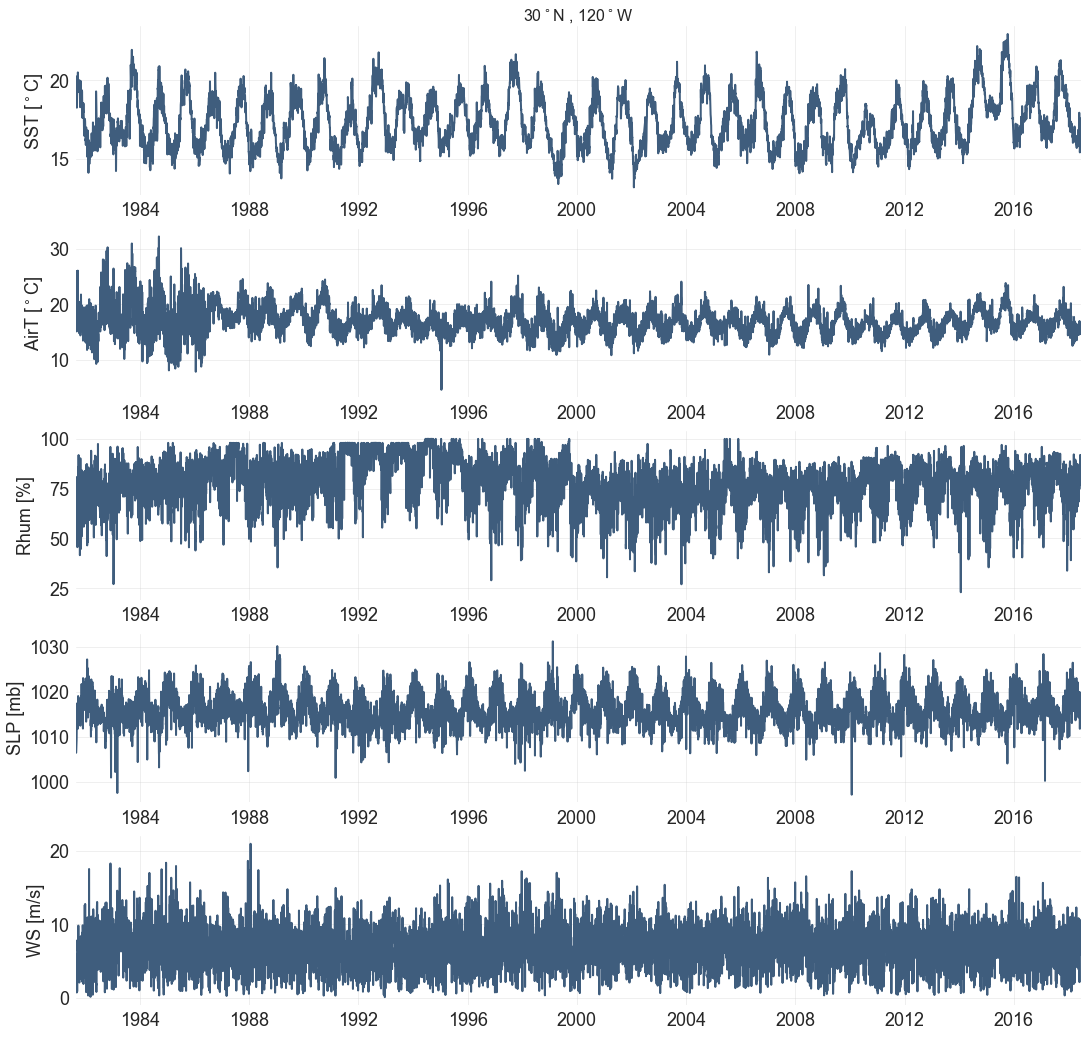

In [273]:
# Plot Time Series
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18)
plt.figure(figsize=(18, 18))

# SST
ax = plt.subplot(511)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)  
ax.spines["left"].set_visible(False)  
ax.tick_params(axis=u'both', which=u'both', length=0)
plt.plot(sst_dates, sst, color="#3F5D7D", linewidth = 2)
plt.ylabel('SST [$^\circ$C]', size=18)
plt.xlim(sst_dates[0], sst_dates[-1])
plt.grid(True, alpha=0.3)
plt.title(lat + '$^\circ$N , ' + lon +'$^\circ$W', fontsize=16)

# Air Temperature
ax = plt.subplot(512)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)  
ax.spines["left"].set_visible(False)  
ax.tick_params(axis=u'both', which=u'both', length=0)
plt.plot(atmo_dates, airt, color="#3F5D7D", linewidth = 2)
plt.ylabel('AirT [$^\circ$C]', size=18)
plt.xlim(atmo_dates[0], atmo_dates[-1])
plt.grid(True, alpha=0.3)

# Relative Humidity
ax = plt.subplot(513)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)  
ax.spines["left"].set_visible(False)  
ax.tick_params(axis=u'both', which=u'both', length=0)
plt.plot(atmo_dates, rhum, color="#3F5D7D", linewidth = 2)
plt.ylabel('Rhum [%]', size=18)
plt.xlim(atmo_dates[0], atmo_dates[-1])
plt.grid(True, alpha=0.3)

# Sea Level Pressure
ax = plt.subplot(514)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)  
ax.spines["left"].set_visible(False)  
ax.tick_params(axis=u'both', which=u'both', length=0)
plt.plot(atmo_dates, slp, color="#3F5D7D", linewidth = 2)
plt.ylabel('SLP [mb]', size=18)
plt.xlim(atmo_dates[0], atmo_dates[-1])
plt.grid(True, alpha=0.3)

# Wind Speed
ax = plt.subplot(515)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)  
ax.spines["left"].set_visible(False)  
ax.tick_params(axis=u'both', which=u'both', length=0)
plt.plot(atmo_dates, ws, color="#3F5D7D", linewidth = 2)
plt.ylabel('WS [m/s]', size=18)
plt.xlim(atmo_dates[0], atmo_dates[-1])
plt.grid(True, alpha=0.3)

***
### Exploratory Data Anslysis
Let's look at how these variables are correlated and what meaningful relationships there might be.

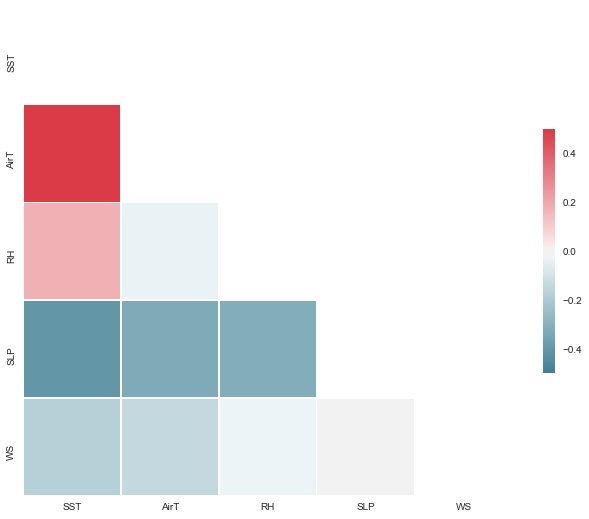

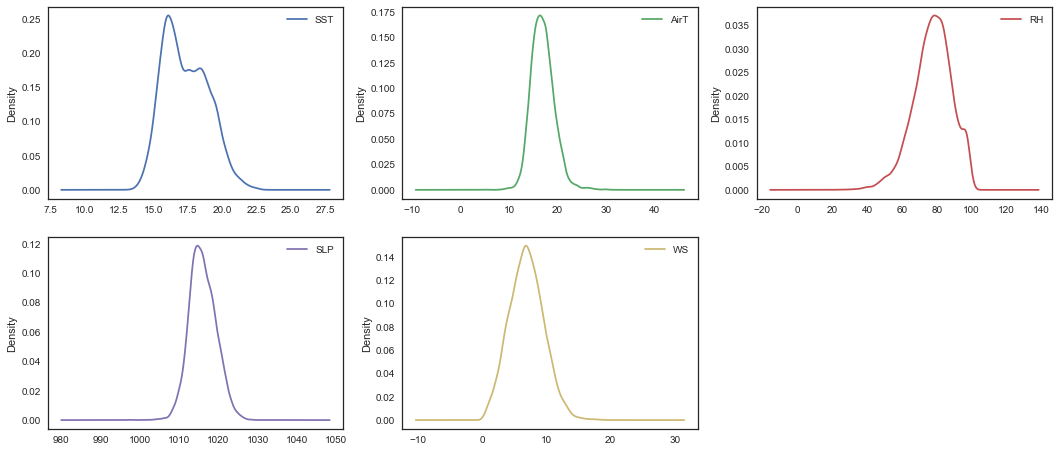

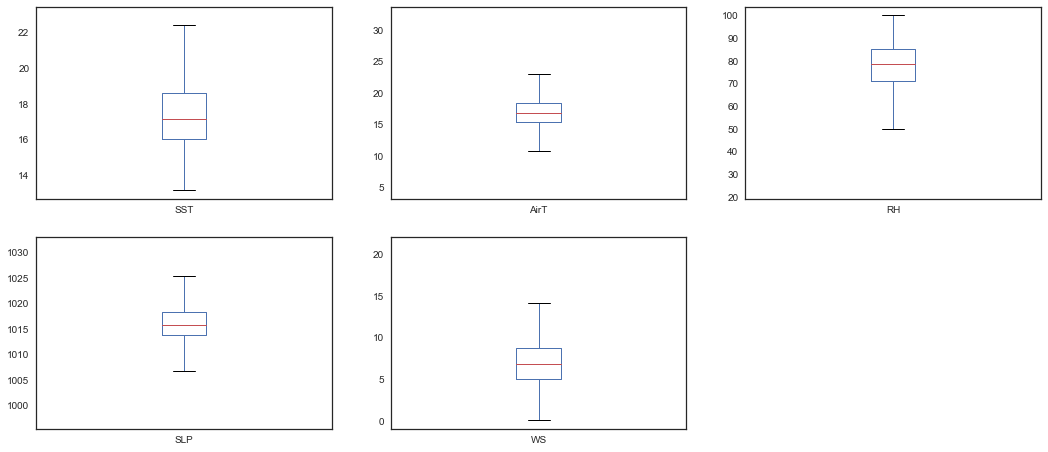

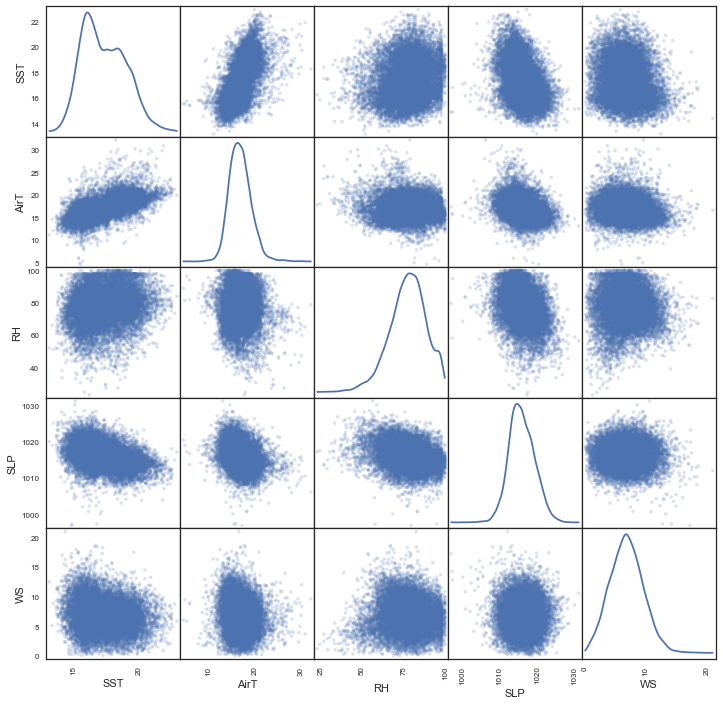

In [274]:
data = DataFrame(np.transpose(np.array([sst, airt, rhum, slp, ws])), columns=['SST','AirT','RH','SLP','WS'])

# Correlation matrix
sns.set(style="white")
corr = data.corr()
mask = np.zeros_like(corr, dtype=np.bool) # Generate a mask for the upper triangle
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True) # Generate a custom diverging colormap
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.5, vmin=-0.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

# Density
data.plot(kind='density',figsize=(18, 12), subplots=True, layout=(3,3), sharex=False)
plt.show()

# Box and Whiskers
data.plot(kind='box',figsize=(18, 12), subplots=True, layout=(3,3), sharex=False, sharey=False)
plt.show()

# Scatter Matrix 
pd.plotting.scatter_matrix(data, alpha=0.2, figsize=(12, 12), diagonal='kde')
plt.show()

### Missing Values
**Let's loook at our data structure and check for missing values**

In [275]:
# Data = (timesteps, features)
data = DataFrame(np.transpose(np.array([sst, airt, rhum, slp, ws])), columns=['SST','AirT','RH','SLP','WS'])
print('Data: ', data.shape)
print (data.head())
print('')

# search for missing values
values = data.values
values = values.astype('float32')
null_data = data[data.isnull().any(axis=1)]
print('Missing values: ', null_data.shape)
print(null_data)
print('')

missing = np.any(np.isnan(values))
finite = np.all(np.isfinite(values)) # determines whether the passed value is a finite number. 
print('Are there missing values in my data?..', missing)
print('Are my values finite?..', finite)

Data:  (13433, 5)
         SST       AirT         RH          SLP        WS
0  18.559999  21.860016  80.059998  1006.420044  5.956861
1  18.629999  21.059998  80.190002  1006.920044  5.552516
2  18.400000  20.250000  80.309998  1007.420044  5.159316
3  18.359999  19.449982  80.440002  1007.920044  4.780041
4  19.049999  18.649994  80.569992  1008.420044  4.428237

Missing values:  (2, 5)
        SST       AirT     RH          SLP        WS
7693  18.85  20.250000  37.75  1013.490051       NaN
9032  16.66  16.559998    NaN  1015.000000  3.939531

Are there missing values in my data?.. True
Are my values finite?.. False


**Oh no! There are missing values!**

To fill missing values we will linearly interpolate using the pandas series ```interpolate(method='linear', axis=0, limit=5)```. We set the maximum number of consecutive NaNs to fill equal to 5. 

In [276]:
# linearly interpolate missing values column wise
interpval = data.interpolate(method='linear', axis=0, limit=5) 

null_data_ind = null_data.index.tolist()
print('Interpolated Values:')
print(interpval.iloc[null_data_ind])

Interpolated Values:
        SST       AirT     RH          SLP        WS
7693  18.85  20.250000  37.75  1013.490051  6.372299
9032  16.66  16.559998  74.75  1015.000000  3.939531


Let's update the data with the interpolated values and create an array for time that coincides with it. We will create a ```time``` array with days since 0000-01-01 00:00:00 and a ```dates``` array for oridnal time.

In [367]:
# Update data with interpolated values
data = interpval

# Let's create an array for time that coincides with the data. ```time``` will be 
time = DataFrame(atmo_time)
time = time.values
dates = [date.fromordinal(tt) for tt in time]
dates = np.array(dates)

In [368]:
# And let's make sure the dimensions of our arrays hasn't changed!
print(data.shape, time.shape, dates.shape)

(13433, 5) (13433, 1) (13433,)


***
# 1. Data Prep
1. Normalize features
2. Create lagged series
3. Divide data into a training and test set


### Normalize features

In [369]:
values = data.values
values = values.astype('float32') # ensure all data is float

# normalize features in range -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(values)

### Create lagged supervised series

In [371]:
n_features = data.shape[1]       # SST, airT, RH, SLP, WS
lag = 100                        # input sequence (length of samples will be reduced by the # of lags)
steps = 21                       # forecast sequence

In [372]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True): # 
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# frame as supervised learning
reframed = series_to_supervised(scaled, lag, steps)

print(reframed.head())
print('Size of supervised series =', reframed.shape, ' = [#samlples, (n_features*lags + n_features*steps)]')
values = reframed.values
dates = dates[lag:] # length of samples was reduced by #lag

     var1(t-100)  var2(t-100)  var3(t-100)  var4(t-100)  var5(t-100)  \
100     0.102250     0.248919     0.482078    -0.452736    -0.437509   
101     0.116565     0.191197     0.485455    -0.423470    -0.476162   
102     0.069530     0.132756     0.488571    -0.394203    -0.513751   
103     0.061350     0.075035     0.491948    -0.364937    -0.550008   
104     0.202454     0.017315     0.495324    -0.335670    -0.583639   

     var1(t-99)  var2(t-99)  var3(t-99)  var4(t-99)  var5(t-99)     ...       \
100    0.116565    0.191197    0.485455   -0.423470   -0.476162     ...        
101    0.069530    0.132756    0.488571   -0.394203   -0.513751     ...        
102    0.061350    0.075035    0.491948   -0.364937   -0.550008     ...        
103    0.202454    0.017315    0.495324   -0.335670   -0.583639     ...        
104    0.229039   -0.040404    0.498701   -0.306408   -0.616113     ...        

     var1(t+998)  var2(t+998)  var3(t+998)  var4(t+998)  var5(t+998)  \
100     0.3905

### Split data into training and testing sets

Stateful LSTMs must have a training set size that is divisible by the batch size. 

In [373]:
## split into input and outputs
n_obs = lag*n_features
print('total number of n_obs (lags x features) =', n_obs)
print('dates size =',dates.shape)
print('')

train = train = values[:-steps, :] # values[:train_length, :] 
test = test = values[-steps:, :] # values[train_length:, :] 
print('train = [#samles, (n_features*lags + n_features*steps)] =', train.shape)
print('test = [#samples, (n_features*lags + n_features*steps)] =', test.shape) 
print('')

xtrain, ytrain = train[:, :n_obs], train[:, -n_features]
xtest, ytest = test[:, :n_obs], test[:, -n_features] 
print('xtrain =',xtrain.shape)
print('ytrain =', ytrain.shape)
print('')

# reshape input to be 3D [samples, timesteps, features]
Xtrain = xtrain.reshape((xtrain.shape[0], lag, n_features))
Xtest = xtest.reshape((xtest.shape[0], lag, n_features))
print('**[samles, input sequence, features]**')
print('training set =', Xtrain.shape)
print('test set =', Xtest.shape)

total number of n_obs (lags x features) = 500
dates size = (13333,)

train = [#samles, (n_features*lags + n_features*steps)] = (11334, 5500)
test = [#samples, (n_features*lags + n_features*steps)] = (1000, 5500)

xtrain = (11334, 500)
ytrain = (11334,)

**[samles, input sequence, features]**
training set = (11334, 100, 5)
test set = (1000, 100, 5)


# Batch-size and training-set size
batch_size = 120                    

def get_train_length(dataset, batch_size, test_percent):
    # subtract test_percent to be excluded from training, reserved for test set
    length = len(dataset)
    length *= 1-test_percent
    train_length_values = []
    for x in range(int(length)-100, int(length)):
        mod = x%batch_size
        if (mod == 0):
            train_length_values.append(x)
    return (max(train_length_values))

train_length = get_train_length(xtrain, batch_size, 0.1) # find the training length that is divisible by our batch size
print('training data length =',train_length)

Xtrain = Xtrain[-train_length:,:,:]
ytrain = ytrain[-train_length:]
print(Xtrain.shape, ytrain.shape)

***
## 2. Modeling

### Define  LSTM

- Define LSTM with 40 neurons in the first hidden layer and 1 neuron in the output layer for predicting SST
- Input shape is 1 time step with n_features
- Decisions for which loss function and optimizer to implement

#### <font color=red>What loss function? </font>[(keras loss functions)](https://keras.io/losses/)
- Mean Squared Error ('mean_squared_error')
- Mean Absolute Error ('mae')

#### <font color=red>What optimizer?</font> [(keras optimizers)](https://keras.io/optimizers/)
- Stochastic Gradient Descent (sgd), has parameters: learning rate, learning decay factor, and momentum parameter. [keras documentation](https://keras.io/optimizers/#sgd)
- Adam ('adam'), [keras documentation](https://keras.io/optimizers/#adam), [[Kingma and Ba, 2017]](https://arxiv.org/abs/1412.6980v8)

In [374]:
# Optimization Options: 

#Stochastic Gradient Descent
sgd = SGD(lr=0.01,
         decay=0,    # learning rate decay over each update
         momentum=0)  # updates momentum
# Adam
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

In [375]:
# Activation Options;

# tanh
# softmax
# softplus
# relu
# sigmoid
# hard_sigmoid
# linear

In [383]:
# Design network
LSTM1_neurons = 30
output_neurons = 1 # fully connected layer
dropout = 0.2 
rdropout = 0.2

# Build model
model = Sequential()
model.add(LSTM(LSTM1_neurons, input_shape=(Xtrain.shape[1], Xtrain.shape[2]), dropout=dropout, activation='tanh'))
#model.add(LSTM(LSTM1_neurons, batch_input_shape=(batch_size, Xtrain.shape[1], Xtrain.shape[2]), dropout=dropout, recurrent_dropout=rdropout, stateful=True))
model.add(Dense(output_neurons, activation='tanh'))   
model.compile(loss='mean_squared_error',
              optimizer=sgd,
              metrics=['accuracy'])
model.summary()
model.get_config()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 30)                4320      
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 31        
Total params: 4,351
Trainable params: 4,351
Non-trainable params: 0
_________________________________________________________________


[{'class_name': 'LSTM',
  'config': {'name': 'lstm_26',
   'trainable': True,
   'batch_input_shape': (None, 100, 5),
   'dtype': 'float32',
   'return_sequences': False,
   'return_state': False,
   'go_backwards': False,
   'stateful': False,
   'unroll': False,
   'units': 30,
   'activation': 'tanh',
   'recurrent_activation': 'hard_sigmoid',
   'use_bias': True,
   'kernel_initializer': {'class_name': 'VarianceScaling',
    'config': {'scale': 1.0,
     'mode': 'fan_avg',
     'distribution': 'uniform',
     'seed': None}},
   'recurrent_initializer': {'class_name': 'Orthogonal',
    'config': {'gain': 1.0, 'seed': None}},
   'bias_initializer': {'class_name': 'Zeros', 'config': {}},
   'unit_forget_bias': True,
   'kernel_regularizer': None,
   'recurrent_regularizer': None,
   'bias_regularizer': None,
   'activity_regularizer': None,
   'kernel_constraint': None,
   'recurrent_constraint': None,
   'bias_constraint': None,
   'dropout': 0.2,
   'recurrent_dropout': 0.0,
   'imp

### Fit network to training data

In [384]:
# Fit network
epochs = 20 # number of full passes over all the training data
batch_size = 800

history = model.fit(Xtrain, ytrain, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    #validation_split=0.2,
                    validation_data=(Xtest, ytest), 
                    verbose=1, 
                    shuffle=False)

Train on 11334 samples, validate on 1000 samples
Epoch 1/20
11334/11334 [==============================] - 4s 334us/step - loss: 0.1216 - acc: 0.0020 - val_loss: 0.1284 - val_acc: 0.0020
Epoch 2/20
11334/11334 [==============================] - 2s 158us/step - loss: 0.1173 - acc: 0.0020 - val_loss: 0.1282 - val_acc: 0.0020
Epoch 3/20
11334/11334 [==============================] - 2s 159us/step - loss: 0.1153 - acc: 0.0020 - val_loss: 0.1271 - val_acc: 0.0020
Epoch 4/20
11334/11334 [==============================] - 2s 161us/step - loss: 0.1133 - acc: 0.0020 - val_loss: 0.1257 - val_acc: 0.0020
Epoch 5/20
11334/11334 [==============================] - 2s 159us/step - loss: 0.1121 - acc: 0.0020 - val_loss: 0.1241 - val_acc: 0.0020
Epoch 6/20
11334/11334 [==============================] - 2s 158us/step - loss: 0.1114 - acc: 0.0020 - val_loss: 0.1224 - val_acc: 0.0020
Epoch 7/20
11334/11334 [==============================] - 2s 160us/step - loss: 0.1096 - acc: 0.0020 - val_loss: 0.1209 - v

In [388]:
# Evaluate model
score = model.evaluate(Xtest, ytest, batch_size=batch_size, verbose=0)
print(score)
print('Test loss: %0.2f' % score[0])
print('Test accuracy: %0.4f' % score[1])

[0.10699222832918168, 0.0019999999552965165]
Test loss: 0.11
Test accuracy: 0.0020


### Make predictions

In [389]:
# Make a prediction
yhat = model.predict(Xtest) # predict on new features
Xtestt = Xtest.reshape((Xtest.shape[0], lag*n_features))

# Invert scaling for forecast
inv_yhat = concatenate((yhat, Xtestt[:, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# Invert scaling for actual
ytesty = ytest.reshape((len(ytest), 1))
inv_y = concatenate((ytesty, Xtestt[:, -(n_features-1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.600


### Visualize Neural Network Model 

In [345]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='LSTM_network.png', show_shapes=True, show_layer_names=True)

***
## 3. Model evaluation
<font color=red>Did we consider cross-validation?</font>

### Run model diagnostics

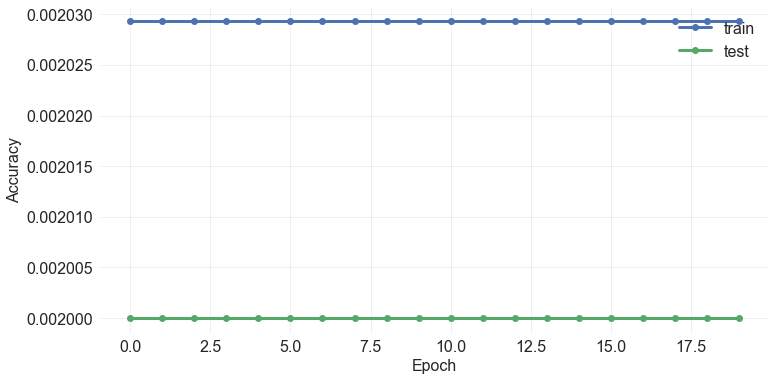

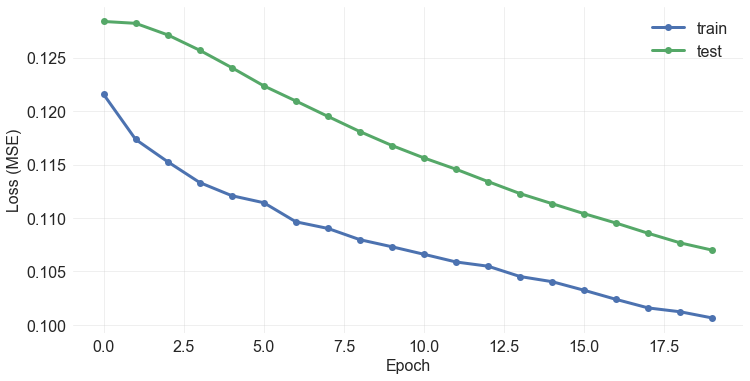

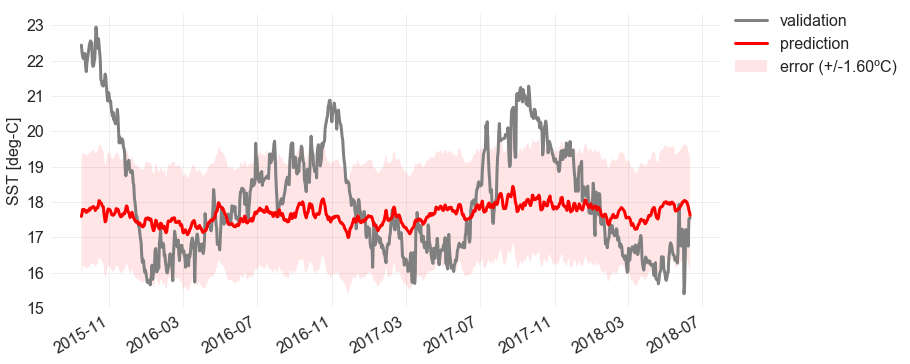

In [393]:
#print(history.history.keys())
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)

#  Summarize history for accuracy
plt.figure(figsize=(12,6)); ax = plt.subplot(111) 
plt.plot(history.history['acc'], 'o-', label='train', linewidth=3)
plt.plot(history.history['val_acc'], 'o-', label='test', linewidth=3)
plt.ylabel('Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.legend(loc='upper right', fontsize=16)
plt.grid(True,alpha = 0.3)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 
ax.spines["left"].set_visible(False) 
ax.spines["bottom"].set_visible(False) 
ax.tick_params(axis=u'both', which=u'both',length=0)

# Summarize history for loss
plt.figure(figsize=(12,6)); ax = plt.subplot(111) 
plt.plot(history.history['loss'], 'o-', linewidth=3)
plt.plot(history.history['val_loss'], 'o-', linewidth=3)
plt.ylabel('Loss (MSE)', fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.legend(['train', 'test'], loc='upper right', fontsize=16)
plt.grid(True,alpha = 0.3)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 
ax.spines["left"].set_visible(False) 
ax.spines["bottom"].set_visible(False) 
ax.tick_params(axis=u'both', which=u'both', length=0)


# Plot prediction
err_up = inv_yhat+rmse
err_lw = inv_yhat-rmse
plt.figure(figsize=(12,6)); ax = plt.subplot(111) 
#plt.plot(dates[-(lag+steps):-steps], data['SST'].values[-(lag+steps):-steps], color="black", label='training')
plt.plot(dates[-steps:], inv_y, color="gray", label='validation', linewidth=3)
plt.plot(dates[-steps:], inv_yhat, label='prediction', color="red", linewidth=3)
plt.fill_between(dates[-steps:], err_up, err_lw, facecolor='red', interpolate=True, alpha = 0.1, label="error (+/-%0.2fºC)" % rmse)
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.05), fontsize=16)
plt.ylabel('SST [deg-C]', fontsize=16)
plt.grid(True,alpha = 0.3)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 
ax.spines["left"].set_visible(False) 
ax.spines["bottom"].set_visible(False) 
ax.tick_params(axis=u'both', which=u'both', length=0)
plt.gcf().autofmt_xdate()


### Visualize layer representations

In [398]:
for layer in model.layers:
    print(layer.name, ', is trainable?',layer.trainable)
    print('Layer Configuration:')
    print(layer.get_config(), end='\n{}\n'.format('----'*10))

lstm_26 , is trainable? True
Layer Configuration:
{'name': 'lstm_26', 'trainable': True, 'batch_input_shape': (None, 100, 5), 'dtype': 'float32', 'return_sequences': False, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 'units': 30, 'activation': 'tanh', 'recurrent_activation': 'hard_sigmoid', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'recurrent_initializer': {'class_name': 'Orthogonal', 'config': {'gain': 1.0, 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'unit_forget_bias': True, 'kernel_regularizer': None, 'recurrent_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'recurrent_constraint': None, 'bias_constraint': None, 'dropout': 0.2, 'recurrent_dropout': 0.0, 'implementation': 1}
----------------------------------------
dense_26 , is trainable? True

### Look at feature weights

In [402]:
L1w_input = np.asarray(model.layers[0].get_weights()[0]) # ?
L1w = np.asarray(model.layers[0].get_weights()[1]) # first layer weight
L1b = np.asarray(model.layers[0].get_weights()[2]) # first layer bias

L2w = np.asarray(model.layers[1].get_weights()[0]) # second layer weight 
L2b = np.asarray(model.layers[1].get_weights()[1]) # second layer bias

print('Layer 1:  input weight =', L1w_input.shape,' weights =',L1w.shape,' bias ', L1b.shape)
print('Layer 2:  weight =', L2w.shape,' bias =', L2b.shape)


Layer 1:  input weight = (5, 120)  weights = (30, 120)  bias  (120,)
Layer 2:  weight = (30, 1)  bias = (1,)


4.0
4.0


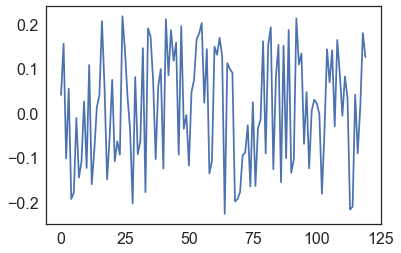

In [403]:
print(200/50)
print(160/40)
plt.plot(L1w_input[4,:]);

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(L1w_input[0]);

plt.figure(figsize=(6,6))
plt.plot(L1w_input[1]);

plt.figure(figsize=(6,6))
plt.plot(L1w_input[2]);

plt.figure(figsize=(6,6))
plt.plot(L1w_input[3]);

plt.figure(figsize=(6,6))
plt.plot(L1w_input[4]);


## 4. Marine heatwave prediction 
 Compute SST climatology and marine heatwave thresholds
- Use the [*marineHeatWave*](https://github.com/ecjoliver/marineHeatWaves) module by Eric Oliver to calculate the daily seasonal SST climatology and MHW thresholds


In [404]:
sst = data['SST']
sst = np.array(sst)

mhw, clim = detect(time, sst, climatologyPeriod=[1988, 2017], 
       pctile=90, windowHalfWidth=5, smoothPercentile=True, 
       smoothPercentileWidth=31, minDuration=5, 
       joinAcrossGaps=True, maxGap=2, maxPadLength=False, 
       coldSpells=False, alternateClimatology=False)


sst_clim = clim['seas'] # seasonal climatology computed between 1988-2017
mhw_thres = clim['thresh'] # marine heatwave threshold computed as the 90th percentile from the seasonal climatology

#### Plot predictions on top of climatology and observations

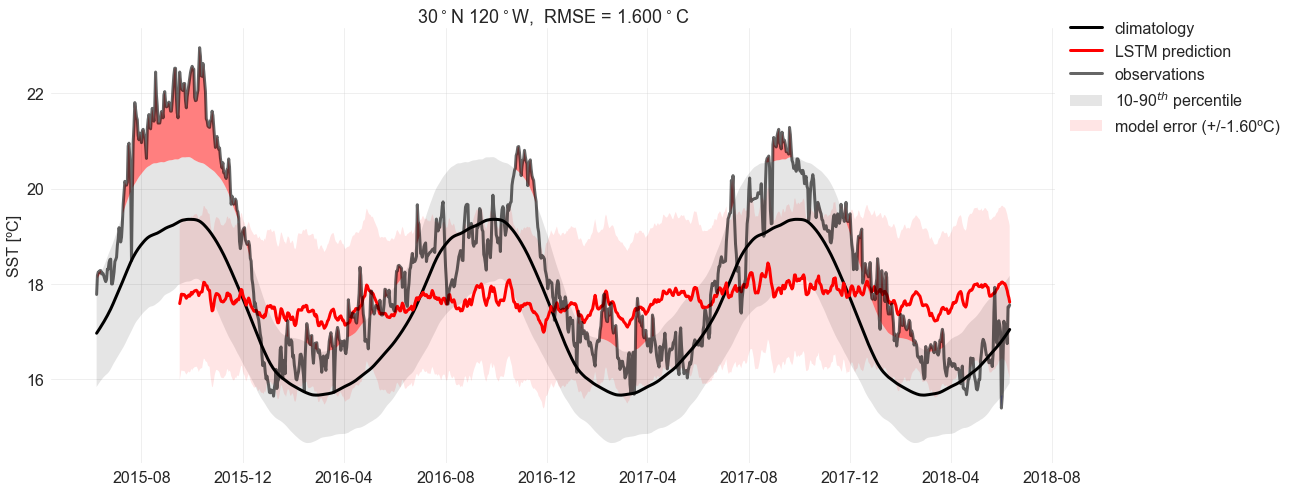

In [405]:
# Make figure, define axis, set default font size
plt.figure(figsize=(18,8))
ax = plt.subplot(111)
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)

# Plot climatology, SST observations, prediction and overlay shading for model error and marine heatwave thresholds
plt.plot(time[-(lag+steps):], sst_clim[-(lag+steps):], linewidth = 3, color="black", label="climatology")
plt.plot(time[-steps:], inv_yhat, label='LSTM prediction', linewidth = 3, color='red') 
plt.plot(dates[-(lag+steps):], data['SST'].values[-(lag+steps):], color="black", alpha=0.6,  linewidth=3, label='observations')
y1 = sst_clim[-(lag+steps):]
y2 = mhw_thres[-(lag+steps):]
y3 = data['SST'].values[-(lag+steps):]
dely = y1-(y2-y1) # ad hoc way to find 10th percentile
plt.fill_between(sst_dates[-(lag+steps):], dely, y2, facecolor='black', interpolate=True, alpha=0.1, label="10-90$^{th}$ percentile")
plt.fill_between(dates[-steps:], err_up, err_lw, facecolor='red', interpolate=True, alpha = 0.1, label="model error (+/-%0.2fºC)" % rmse)
plt.fill_between(dates[-(lag+steps):], y2, y3, where=y2 <= y3,  facecolor='red',interpolate=True, alpha = .5)
plt.fill_between(dates[-(lag+steps):], y3, dely, where=y3 <= dely,  facecolor='blue',alpha = 0.5)

# Make viz pretty
plt.legend(loc="lower right", fontsize=14, frameon=False, ncol=4)
plt.title(lat+'$^\circ$N '+lon+'$^\circ$W,  RMSE = %.3f$^\circ$C' % rmse, fontsize=18)
plt.ylabel('SST [ºC]', size=16)
plt.grid(True, alpha=0.3)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 
ax.spines["left"].set_visible(False) 
ax.spines["bottom"].set_visible(False) 
ax.tick_params(axis=u'both', which=u'both', length=0)
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.05), fontsize=16);

***
**Coding Inspiration:** The following code was created by adapting methods from the following blogs and websites:
- https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/
- https://machinelearningmastery.com/setup-python-environment-machine-learning-deep-learning-anaconda/

Marine Heatwave Dectection Module ([Hobday et al., 2016](https://www.sciencedirect.com/science/article/pii/S0079661116000057))
- https://github.com/ecjoliver/marineHeatWaves